# ------------- User's settings -------------
This is the only section you need to make inputs

In [1]:
# Output from Step1 is needed as input here
input_directory = '../Data/Step1/Output/'

# Output location for this step
output_directory = '../Data/Step2/Output/'

# Define labels of the classes
labels = ['Unannotated']

# Define other metadata
day_of_exp = [str('D'+str(i)) for i in list(range(1,100))] 

# If using Conda, specifying the path for Python site-packages might be needed
import sys
# sys.path.insert(0, '/home/user/.conda/envs/env_names/lib/python3.6/site-packages')

# ------------- Executable -------------
Execute the rest of the script

Beware: it may take very long, read below!

In [2]:
%matplotlib inline

import glob
import os
import skimage.io
import keras
import matplotlib.pyplot
import numpy
import pandas
import pkg_resources
import tensorflow
import deepometry.model_regression as deepometry_model
import deepometry.utils
import itertools
import re
from collections import Counter

# Choose GPU to run training session
configuration = tensorflow.ConfigProto()
configuration.gpu_options.visible_device_list = "1"

def collect_pathnames(directories):

    pathnames = []

    for directory in directories:
        subdirectories = sorted(glob.glob(os.path.join(directory, "*")))
        
        filelist = [glob.glob("{}/*".format(subdirectory)) for subdirectory in subdirectories ]    

        pathnames += [list(numpy.random.permutation(pathnames))[:13000] for pathnames in filelist]

    pathnames = sum(pathnames, [])

    return pathnames


def load(pathnames, dates):
  
    x = numpy.empty((len(pathnames),) + _shape(pathnames[0]), dtype=numpy.uint8)
    
    z = numpy.empty((len(pathnames),), dtype=numpy.uint8)
      
    day_to_index = {day: index for index, day in enumerate(day_of_exp)}    

    for index, pathname in enumerate(pathnames):
        if os.path.isfile(pathname) == True:

            day = re.search('.*_[A-Za-z0-9]*_([DdWw][0-9]{1,2})_.*__', os.path.basename(pathname)).group(1)

            x[index] = numpy.load(pathname)
            
            z[index] = day_to_index[day]
            
    return x, z


def _shape(pathname):

    return numpy.load(pathname).shape     
            

Using TensorFlow backend.


In [3]:
pathnames = collect_pathnames(glob.glob(os.path.join(input_directory, "*/*")))
xx, z = load(pathnames, day_of_exp)

Re-order the channel if needed.

For example:

- When using TIFF input, data may be structured as Brightfield_1 - Darkfield - Brightfield_9
- When using CIF input, data may be structured as Brightfield_1 - Brightfield_9 - Darkfield

In [4]:
# x = numpy.empty((xx.shape[0],48,48,3))
# x[:,:,:,0] = xx[:,:,:,0]
# x[:,:,:,1] = xx[:,:,:,2]
# x[:,:,:,2] = xx[:,:,:,1]
# del(xx)
#x = numpy.empty((xx.shape[0],48,48,2))
#x[:,:,:,0] = xx[:,:,:,2]
#x[:,:,:,1] = xx[:,:,:,1]
#del(xx)
x = numpy.empty((xx.shape[0],48,48,1))
x[:,:,:,0] = xx[:,:,:,0]
del(xx)

print("x: ", x.shape)
print("z: ",Counter(z))

x:  (5657, 48, 48, 1)
z:  Counter({13: 5657})


------------- Verify loaded images -------------

/Users/minhdoan/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


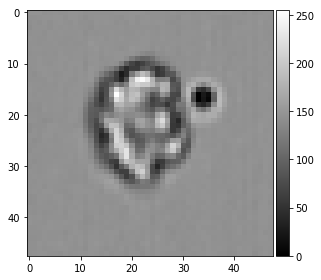

In [5]:
skimage.io.imshow(x[0,:,:,0], cmap='gray')

------------- Train the neural network -------------

Beware: this step may take hours, days, or weeks

In [6]:
configuration.gpu_options.allow_growth = True
session = tensorflow.Session(config = configuration)
# apply session
keras.backend.set_session(session)

model = deepometry_model.Model(shape=x.shape[1:], units=1)

model.compile()

In [ ]:
model.fit(
    x,
    z,
    balance_train=False,
    class_weight=None,
    batch_size=128,
    epochs=512,
    validation_split=0.2,
    verbose=1
)

Epoch 1/512
 1/35 [..............................] - ETA: 30:30 - loss: 4.0275 - mean_absolute_error: 4.0275

------------- Save the trained neural network -------------

In [ ]:
if not os.path.exists(output_directory):
     os.makedirs(output_directory)
    
model.model.save( os.path.join(output_directory, 'model.h5') )